In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from gproc.classifiers import simple_laplace, bayesian_logreg, gridsearch_laplace, full_bayesian_pseudo_marginal
from gproc.run_pipeline import run_pipeline
from gproc.cross_validation import run_cv
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential, periodic, SquaredExponential
from gproc.metrics import inspect_metrics, predictive_metrics, max_threshold, abstention_metrics

In [2]:
N_train = 100
N_test = 50

x = np.random.uniform(-1, 1, N_train + N_test).reshape(-1, 1) # Reshape to N x 1 matrix
kernel = SquaredExponential(lengthscale = 1, variance = 1)

y, prob_y, f = sample_at_x(x, kernel)

# Static F
# f = np.ones_like(x)
# f[x < 0.] = -1
# prob_y = norm.cdf(f)
# y = np.random.binomial(1, p=prob_y) # 1 sample for each N of elements of prob_y
# y[y == 0] = -1
# y = y.reshape(-1)

train_ix, test_ix = np.split(np.random.permutation(np.arange(N_train + N_test)), [N_train])
train_x = x[train_ix,:]
train_y = y[train_ix]
test_x = x[test_ix,:]
test_y = y[test_ix]

In [3]:
classifiers = {
    'fixed_sq_exp': lambda train_x, train_y: simple_laplace(train_x, train_y, squared_exponential),
    'grid_sq_exp': lambda train_x, train_y: gridsearch_laplace(
        train_x, train_y, 
        squared_exponential, 
        (
            np.linspace(1e-3, 2, 10), # Lengthscale
            np.linspace(1e-3, 4, 10), # Variance
        )
    ),
    'blr': bayesian_logreg,
    'full_bayesian': lambda train_x, train_y: full_bayesian_pseudo_marginal(train_x, train_y, SquaredExponential),
}

pred_probs = {
    label: classifier(train_x, train_y)[0](test_x)
    for label, classifier in classifiers.items()
}

Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 81.52it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.88it/s]


/home/th17628/projects/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


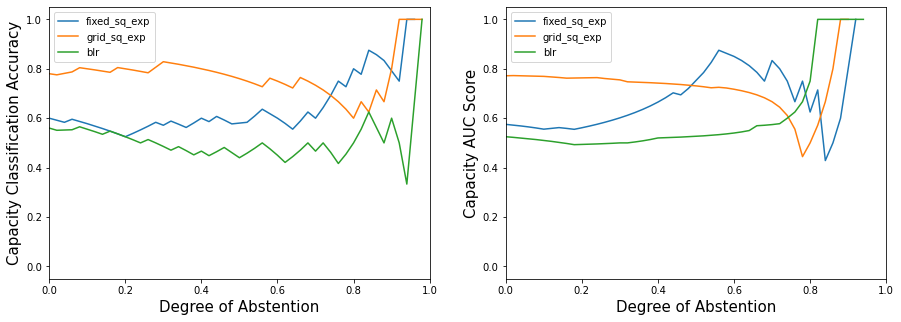

In [4]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
for label, classifier in classifiers.items():
    cap_metrics = run_pipeline(classifier, train_x, train_y, test_x, test_y)
    inspect_metrics(axarr[0], axarr[1], cap_metrics, label=label)
plt.show()

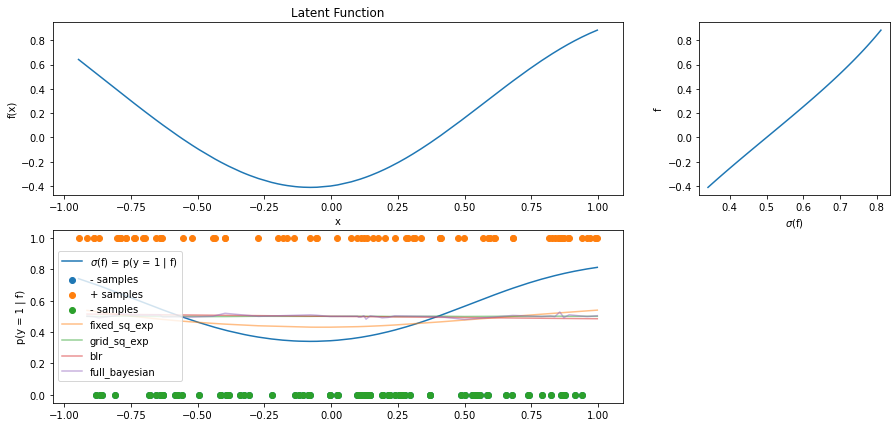

In [4]:
sort_ix = np.argsort(x.reshape(-1))
sorted_x = x.reshape(-1)[sort_ix]

fig, axarr = plt.subplots(2, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

axarr[0, 0].plot(sorted_x, f[sort_ix])
axarr[0, 0].set_xlabel('x')
axarr[0, 0].set_ylabel('f(x)')
axarr[0, 0].set_title('Latent Function')

f_domain = np.linspace(np.min(f), np.max(f), 50)

axarr[0, 1].plot(norm.cdf(f_domain), f_domain)
axarr[0, 1].set_ylabel('f')
axarr[0, 1].set_xlabel('$\sigma$(f)')

axarr[1, 0].plot(sorted_x, prob_y[sort_ix], label='$\sigma$(f) = p(y = 1 | f)')
plot_y = y.copy()[sort_ix]
plot_y[plot_y == -1] = 0
axarr[1, 0].scatter(sorted_x[plot_y == 0], plot_y[plot_y == 0], label='- samples')
axarr[1, 0].scatter(sorted_x[plot_y == 1], plot_y[plot_y == 1], label='+ samples')
axarr[1, 0].legend()
axarr[1, 0].set_ylabel('p(y = 1 | f)')

axarr[1, 0].scatter(sorted_x[plot_y == 0], plot_y[plot_y == 0], label='- samples')

axarr[1, 1].axis('off')

test_sort_ix = np.argsort(test_x.reshape(-1))

for label, prob_ests in pred_probs.items():
    axarr[1, 0].plot(test_x[test_sort_ix], prob_ests[test_sort_ix], label=label, alpha=0.5)
axarr[1, 0].legend()


plt.show()

## Cross-Validation

In [7]:
total_n = 100

x = np.random.uniform(-1, 1, total_n).reshape(-1, 1) # Reshape to N x 1 matrix
y, prob_y, f = sample_at_x(
    x, 
    SquaredExponential(lengthscale = 0.05, variance = 2)
)

classifiers = {
    'fixed_sq_exp': lambda train_x, train_y: simple_laplace(train_x, train_y, squared_exponential),
    'grid_sq_exp': lambda train_x, train_y: gridsearch_laplace(
        train_x, train_y, 
        squared_exponential, 
        (
            np.linspace(1e-3, 2, 10), # Lengthscale
            np.linspace(1e-3, 4, 10), # Variance
        )
    ),
    'blr': bayesian_logreg,
    'full_bayesian': lambda train_x, train_y: full_bayesian_pseudo_marginal(train_x, train_y, SquaredExponential),
}

num_splits = 5
results = run_cv(x, y, classifiers, splits=num_splits)

/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.20it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.57it/s]
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:59<00:00, 83.83it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.48it/s]
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 84.89it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.66it/s]
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.92it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.46it/s]
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)
Building: found in cache, done.
Sampling:   0%
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:07<00:00, 74.03it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.61it/s]


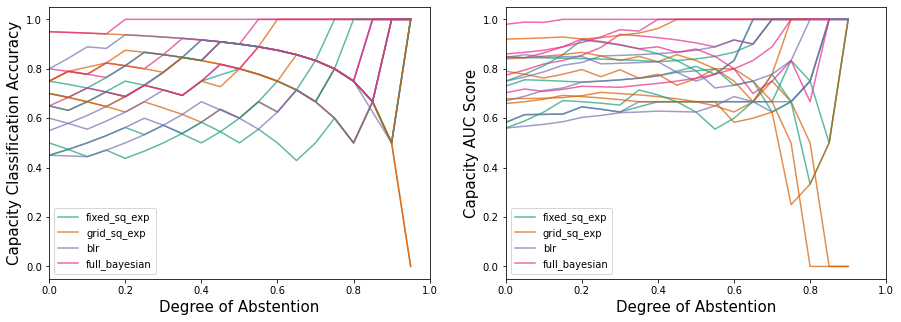

In [8]:
c_map = plt.cm.Dark2(range(len(classifiers)))

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
num_splits = 5

accuracies = {label:[] for label in classifiers}
for split in range(num_splits):
    for ix, label in enumerate(classifiers):
        cap_metrics = results[label][split]
        
        # Record full accuracy
        fold_accuracy = cap_metrics[:, 1][0]
        accuracies[label].append(fold_accuracy)
        
        # Plot cap values
        inspect_metrics(
            axarr[0], axarr[1], cap_metrics, 
            label=label if split == 0 else None, 
            plot_kwargs={'color': c_map[ix], 'alpha': 0.7},
        )
        
plt.show()

In [9]:
{label: np.mean(acc) for label, acc in accuracies.items()}

{'fixed_sq_exp': 0.61,
 'grid_sq_exp': 0.7699999999999999,
 'blr': 0.5700000000000001,
 'full_bayesian': 0.76}